## 用 Cartopy 绘制带刻度的兰伯特投影地图

Cartopy 从 0.18 版本开始能够利用 `GeoAxes.gridlines` 方法给任意投影的地图画上网格线，同时在网格线与坐标轴的交点处标出经纬度值。刚开始还有些显示上的问题，例如会把经度标到 y 轴上，不过已经在 0.20 版本修复（[Issue#1530](https://github.com/SciTools/cartopy/issues/1530)）。

遗憾的是，`gridlines` 的经纬度标签只有文字（`Text`）而没有刻度线（`Tick`）。个人觉得有刻度更好看些，于是写了个可以给 `Geoax_main_maines` 加刻度的函数 `set_extent_and_ticks`，并且放到了自己写的工具箱 `frykit` 里，下载链接见 [https://github.com/ZhaJiMan/frykit](https://github.com/ZhaJiMan/frykit)。别问为什么不是 pip 包的形式，问就是还没学会😭。

原理就是用 `shapely.geometry.LineString` 对象模拟四个坐标轴和经纬线，求它们相交的位置，然后用 `GeoAxes.set_xticks` 方法在地图的投影坐标系进行标注。恐怕源码也没人想看，这里就直接展示一个例子，模仿了 [NCL 官图](https://www.ncl.ucar.edu/Applications/lcnative.shtml) 的风格。

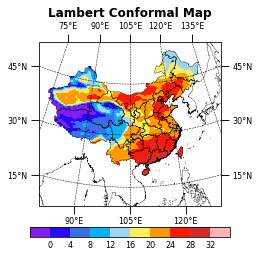

In [2]:
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import frykit.plot as fplt
import cmaps

# 读取数据.
ds = xr.load_dataset('data.nc')
t2m = ds['t2m'].isel(time=0) - 273.15
t2m[:] = gaussian_filter(t2m.values, sigma=1)

# 设置地图范围和刻度.
extents = [80, 130, 10, 55]
xticks = np.arange(60, 151, 15)
yticks = np.arange(0, 61, 15)

# 设置投影.
crs_map = ccrs.LambertConformal(
    central_longitude=105, standard_parallels=(25, 47)
)
crs_data = ccrs.PlateCarree()

# 设置刻度风格.
plt.rc('xtick.major', size=8, width=0.9)
plt.rc('ytick.major', size=8, width=0.9)
plt.rc('xtick', labelsize=8, top=True, labeltop=True)
plt.rc('ytick', labelsize=8, right=True, labelright=True)

# 绘制主地图.
fig = plt.figure()
ax = fig.add_subplot(111, projection=crs_map)
ax.coastlines(resolution='10m', lw=0.3)
fplt.add_cn_province(ax, lw=0.3)
fplt.set_extent_and_ticks(
    ax, extents=extents,
    xticks=xticks, yticks=yticks,
    grid=True, lw=0.5, ls='--', color='k'
)
ax.set_title(
    'Lambert Conformal Map', y=1.12,
    fontsize='large', weight='bold'
)

# 绘制填色图.
levels = np.linspace(0, 32, 9)
cf = ax.contourf(
    t2m.longitude, t2m.latitude, t2m, levels,
    cmap=cmaps.ncl_default, extend='both', transform=crs_data,
)
fplt.clip_by_cn_border(cf, fix=True)
cbar = fig.colorbar(
    cf, ax=ax, orientation='horizontal', shrink=0.6, pad=0.1,
    extendrect=True, extendfrac='auto'
)
cbar.ax.tick_params(length=0, labelsize=8)

# 保存图片.
fig.savefig('lambert.png', dpi=300, bbox_inches='tight')
plt.close(fig)

效果图如下所示，还额外加了一个正射投影的例子。

![lambert](lambert.png)

最后说一下 `set_extent_and_ticks` 函数的缺陷：
- 当传入的地图范围 `extents` 太大时，可能无法保证地图边界呈矩形，此时可能会漏掉刻度，或者把刻度加到虚空位置。
- 当传给函数的刻度位置跨越了日期变更线（180°经线）时，也不保证刻度能正确显示。

如果只是需要经纬度标签，那么新版本 Cartopy 中的 `GeoAxes.gridlines` 网格线已经够用了；如果想要再加上刻度，可以考虑使用本文中提到的函数。